In [1]:
# In [1]: Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans


In [2]:
# In [2]: Load data

# Make sure DataSet.csv is in the same folder as your notebook
df = pd.read_csv("DataSet.csv")

# Quick look
print("Shape:", df.shape)
df.head()


Shape: (10127, 23)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [3]:
# In [3]: Basic info & checking for missing / 'Unknown' values

print(df.info())
print("\nMissing values per column:")
print(df.isna().sum())

# Check how many 'Unknown' values appear in categorical columns
cat_cols = df.select_dtypes(include=["object"]).columns
for col in cat_cols:
    unknown_count = (df[col] == "Unknown").sum()
    if unknown_count > 0:
        print(f"Column '{col}' has {unknown_count} 'Unknown' values")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

In [4]:
# In [4]: Cleaning & selecting features for clustering

df_clean = df.copy()

# Columns to drop (ID, label, and Naive Bayes prediction columns)
cols_to_drop = ["CLIENTNUM", "Attrition_Flag"]
cols_to_drop += [c for c in df_clean.columns if c.startswith("Naive_Bayes_Classifier")]

df_clean = df_clean.drop(columns=cols_to_drop)

print("Remaining columns for clustering:")
print(df_clean.columns.tolist())


Remaining columns for clustering:
['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


In [5]:
# In [5]: Replace 'Unknown' with NaN in categorical columns

cat_cols = df_clean.select_dtypes(include=["object"]).columns
num_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns

df_clean[cat_cols] = df_clean[cat_cols].replace("Unknown", np.nan)

print("Categorical columns:", list(cat_cols))
print("Numeric columns:", list(num_cols))


Categorical columns: ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
Numeric columns: ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


In [6]:
# In [6]: Preprocessing pipeline

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(df_clean)

print("Preprocessed feature matrix shape:", X_preprocessed.shape)


NameError: name 'Pipeline' is not defined

In [7]:
from sklearn.pipeline import Pipeline



In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


In [9]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

X_preprocessed = preprocessor.fit_transform(df_clean)
print("Preprocessed feature matrix shape:", X_preprocessed.shape)


Preprocessed feature matrix shape: (10127, 34)


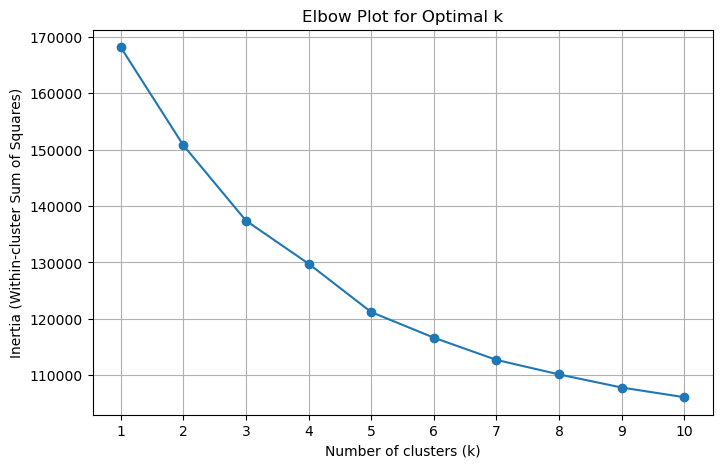

In [10]:
# In [7]: Elbow method for optimal clusters

inertias = []
K_range = range(1, 11)  # you can increase upper limit if you want

for k in K_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init="auto"  # for sklearn >= 1.4, else use n_init=10
    )
    kmeans.fit(X_preprocessed)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(list(K_range), inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Within-cluster Sum of Squares)")
plt.title("Elbow Plot for Optimal k")
plt.xticks(list(K_range))
plt.grid(True)
plt.show()


In [11]:
# In [8]: Fit final KMeans model with chosen k

optimal_k = 4  # <-- change this based on your elbow plot
kmeans_final = KMeans(
    n_clusters=optimal_k,
    random_state=42,
    n_init="auto"
)

cluster_labels = kmeans_final.fit_predict(X_preprocessed)

# Add cluster labels back to original dataframe
df_clusters = df.copy()  # keep original columns
df_clusters["Cluster"] = cluster_labels

df_clusters.head()


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2,Cluster
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991,1
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994,0
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998,0
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987,0
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998,0


In [12]:
# In [9]: Cluster-wise summary (numeric)

cluster_summary_num = df_clusters.groupby("Cluster")[num_cols].mean()
cluster_summary_num


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
Cluster,,,,,,,,,,,,,,
0,42.654455,2.603751,32.511723,3.679660,2.262603,2.292790,4003.468992,1678.062134,2325.406858,0.792013,4988.757913,71.581184,0.760811,0.519967
1,43.667124,2.592732,33.568392,3.939664,2.405211,2.628385,6329.498217,385.647926,5943.850291,0.717581,3479.699006,58.712376,0.651921,0.059354
2,46.300472,2.550177,35.988784,3.411452,2.299882,2.410862,25968.579103,1240.157025,24728.422078,0.771279,6333.028335,73.376623,0.719239,0.053188
3,55.986692,1.422529,44.692490,4.174905,2.413023,2.514734,5371.691825,1342.447243,4029.244582,0.757529,3184.461977,55.620247,0.711380,0.354792


In [13]:
# In [10]: Cluster-wise counts for some categorical columns

for col in ["Gender", "Education_Level", "Marital_Status", "Income_Category", "Card_Category"]:
    if col in df_clusters.columns:
        print(f"\nColumn: {col}")
        display(df_clusters.groupby("Cluster")[col].value_counts(normalize=True).unstack().round(2))



Column: Gender


Gender,F,M
Cluster,,
0,0.68,0.32
1,0.56,0.44
2,0.13,0.87
3,0.57,0.43



Column: Education_Level


Education_Level,College,Doctorate,Graduate,High School,Post-Graduate,Uneducated,Unknown
Cluster,,,,,,,
0,0.1,0.04,0.32,0.20,0.05,0.14,0.15
1,0.1,0.05,0.31,0.19,0.05,0.14,0.16
2,0.1,0.04,0.29,0.20,0.05,0.16,0.15
3,0.1,0.05,0.31,0.21,0.04,0.15,0.14



Column: Marital_Status


Marital_Status,Divorced,Married,Single,Unknown
Cluster,,,,
0,0.08,0.46,0.37,0.08
1,0.08,0.45,0.40,0.08
2,0.09,0.41,0.41,0.09
3,0.05,0.52,0.38,0.04



Column: Income_Category


Income_Category,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Unknown
Cluster,,,,,,
0,0.02,0.21,0.10,0.07,0.49,0.10
1,0.05,0.19,0.15,0.13,0.35,0.13
2,0.23,0.06,0.21,0.39,0.02,0.09
3,0.05,0.19,0.13,0.12,0.39,0.11



Column: Card_Category


Card_Category,Blue,Gold,Platinum,Silver
Cluster,,,,
0,0.99,0.00,NaN,0.01
1,0.97,0.00,0.00,0.02
2,0.68,0.06,0.01,0.25
3,0.98,0.00,NaN,0.02


In [14]:
from sklearn.cluster import KMeans

optimal_k = 4  # can also test k=5 if needed
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init="auto")

cluster_labels = kmeans_final.fit_predict(X_preprocessed)

# Attach clusters to original dataset
df_clusters = df.copy()
df_clusters["Cluster"] = cluster_labels

df_clusters.head()


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2,Cluster
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991,1
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994,0
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998,0
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987,0
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998,0


In [15]:
# Summary of numerical variables
df_clusters.groupby("Cluster")[num_cols].mean()


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
Cluster,,,,,,,,,,,,,,
0,42.654455,2.603751,32.511723,3.679660,2.262603,2.292790,4003.468992,1678.062134,2325.406858,0.792013,4988.757913,71.581184,0.760811,0.519967
1,43.667124,2.592732,33.568392,3.939664,2.405211,2.628385,6329.498217,385.647926,5943.850291,0.717581,3479.699006,58.712376,0.651921,0.059354
2,46.300472,2.550177,35.988784,3.411452,2.299882,2.410862,25968.579103,1240.157025,24728.422078,0.771279,6333.028335,73.376623,0.719239,0.053188
3,55.986692,1.422529,44.692490,4.174905,2.413023,2.514734,5371.691825,1342.447243,4029.244582,0.757529,3184.461977,55.620247,0.711380,0.354792


In [16]:
# Summary of categorical variables
for col in ["Gender", "Education_Level", "Marital_Status", "Income_Category", "Card_Category"]:
    if col in df_clusters.columns:
        print(f"\nColumn: {col}")
        display(df_clusters.groupby("Cluster")[col].value_counts(normalize=True).unstack().round(2))



Column: Gender


Gender,F,M
Cluster,,
0,0.68,0.32
1,0.56,0.44
2,0.13,0.87
3,0.57,0.43



Column: Education_Level


Education_Level,College,Doctorate,Graduate,High School,Post-Graduate,Uneducated,Unknown
Cluster,,,,,,,
0,0.1,0.04,0.32,0.20,0.05,0.14,0.15
1,0.1,0.05,0.31,0.19,0.05,0.14,0.16
2,0.1,0.04,0.29,0.20,0.05,0.16,0.15
3,0.1,0.05,0.31,0.21,0.04,0.15,0.14



Column: Marital_Status


Marital_Status,Divorced,Married,Single,Unknown
Cluster,,,,
0,0.08,0.46,0.37,0.08
1,0.08,0.45,0.40,0.08
2,0.09,0.41,0.41,0.09
3,0.05,0.52,0.38,0.04



Column: Income_Category


Income_Category,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,Unknown
Cluster,,,,,,
0,0.02,0.21,0.10,0.07,0.49,0.10
1,0.05,0.19,0.15,0.13,0.35,0.13
2,0.23,0.06,0.21,0.39,0.02,0.09
3,0.05,0.19,0.13,0.12,0.39,0.11



Column: Card_Category


Card_Category,Blue,Gold,Platinum,Silver
Cluster,,,,
0,0.99,0.00,NaN,0.01
1,0.97,0.00,0.00,0.02
2,0.68,0.06,0.01,0.25
3,0.98,0.00,NaN,0.02


In [17]:
df["Utilization_Ratio"] = df["Total_Revolving_Bal"] / df["Credit_Limit"]
df["Utilization_Ratio"].fillna(0, inplace=True)


In [18]:
X_util = df[["Utilization_Ratio"]].values


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_util)


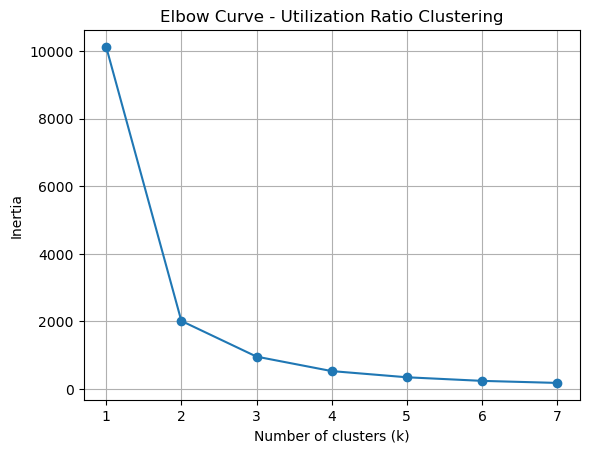

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1, 8)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker="o")
plt.title("Elbow Curve - Utilization Ratio Clustering")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


In [21]:
kmeans_util = KMeans(n_clusters=3, random_state=42, n_init="auto")
df["Utilization_Cluster"] = kmeans_util.fit_predict(X_scaled)


In [22]:
df.groupby("Utilization_Cluster")["Utilization_Ratio"].agg(["count", "mean", "min", "max"])


,count,mean,min,max
Utilization_Cluster,,,,
0,2400,0.694346,0.521080,0.998768
1,5347,0.053668,0.000000,0.200894
2,2380,0.348924,0.201153,0.521057


In [23]:
kmeans_util = KMeans(n_clusters=3, random_state=42, n_init="auto")
df["Utilization_Cluster"] = kmeans_util.fit_predict(X_scaled)


In [24]:
df.groupby("Utilization_Cluster")["Utilization_Ratio"].agg(["count", "mean", "min", "max"])


,count,mean,min,max
Utilization_Cluster,,,,
0,2400,0.694346,0.521080,0.998768
1,5347,0.053668,0.000000,0.200894
2,2380,0.348924,0.201153,0.521057


In [25]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load data (or skip if df already exists)
df = pd.read_csv("DataSet.csv")

# Create Utilization Ratio if not present
if "Utilization_Ratio" not in df.columns:
    df["Utilization_Ratio"] = df["Total_Revolving_Bal"] / df["Credit_Limit"]

df["Utilization_Ratio"] = df["Utilization_Ratio"].fillna(0)

# Scale only the utilization ratio for clustering
scaler_util = StandardScaler()
X_util = scaler_util.fit_transform(df[["Utilization_Ratio"]])

# KMeans on utilization ratio (k=3)
kmeans_util = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Utilization_Cluster"] = kmeans_util.fit_predict(X_util)

df[["Utilization_Ratio", "Utilization_Cluster"]].head()


,Utilization_Ratio,Utilization_Cluster
0,0.061224,1
1,0.104651,1
2,0.000000,1
3,0.759734,0
4,0.000000,1


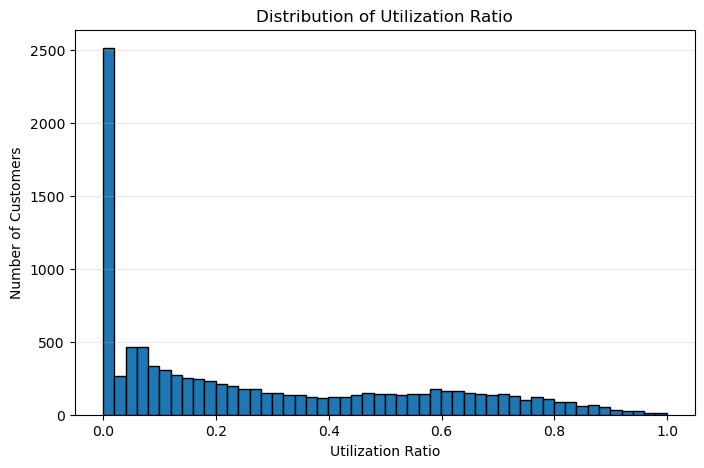

In [26]:
plt.figure(figsize=(8,5))
plt.hist(df["Utilization_Ratio"], bins=50, edgecolor="black")
plt.title("Distribution of Utilization Ratio")
plt.xlabel("Utilization Ratio")
plt.ylabel("Number of Customers")
plt.grid(axis="y", alpha=0.3)
plt.show()


<Figure size 800x500 with 0 Axes>

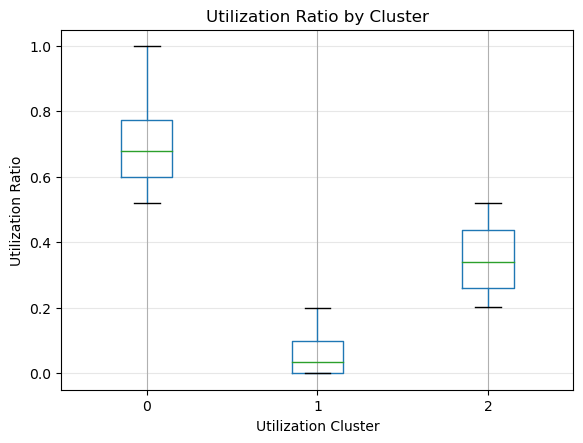

In [27]:
plt.figure(figsize=(8,5))
df.boxplot(column="Utilization_Ratio", by="Utilization_Cluster")
plt.title("Utilization Ratio by Cluster")
plt.suptitle("")   # removes the automatic super title
plt.xlabel("Utilization Cluster")
plt.ylabel("Utilization Ratio")
plt.grid(axis="y", alpha=0.3)
plt.show()


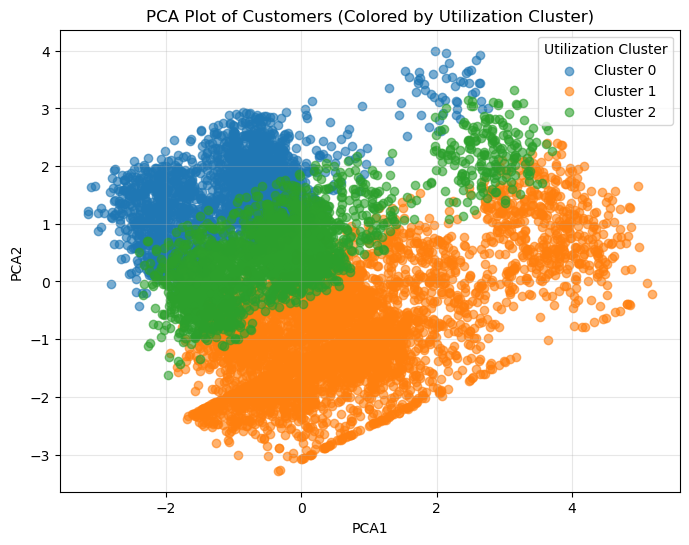

In [28]:
# Choose features to include in PCA (you can adjust this list)
features_for_pca = [
    "Utilization_Ratio",
    "Credit_Limit",
    "Total_Revolving_Bal",
    "Total_Trans_Amt",
    "Total_Trans_Ct"
]

# Keep only columns that exist in the dataframe
features_for_pca = [c for c in features_for_pca if c in df.columns]

X = df[features_for_pca].copy()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df["PCA1"] = X_pca[:, 0]
df["PCA2"] = X_pca[:, 1]

# Scatter plot coloured by Utilization_Cluster
plt.figure(figsize=(8,6))
for c in sorted(df["Utilization_Cluster"].unique()):
    subset = df[df["Utilization_Cluster"] == c]
    plt.scatter(subset["PCA1"], subset["PCA2"], label=f"Cluster {c}", alpha=0.6)

plt.title("PCA Plot of Customers (Colored by Utilization Cluster)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Utilization Cluster")
plt.grid(alpha=0.3)
plt.show()


In [29]:
# Use appropriate columns from your dataset
R_col = "Months_Inactive_12_mon"  # lower is better (more recent)
F_col = "Total_Trans_Ct"
M_col = "Total_Trans_Amt"

rfm = df[["CLIENTNUM", R_col, F_col, M_col]].copy()
rfm.rename(columns={
    R_col: "Recency_raw",
    F_col: "Frequency_raw",
    M_col: "Monetary_raw"
}, inplace=True)

rfm.head()


,CLIENTNUM,Recency_raw,Frequency_raw,Monetary_raw
0,768805383,1,42,1144
1,818770008,1,33,1291
2,713982108,1,20,1887
3,769911858,4,20,1171
4,709106358,1,28,816


In [30]:
# --- Recency score: fewer inactive months = better (score 5) ---
# qcut on Recency_raw with reversed labels so smaller value → higher score
rfm["R_Score"] = pd.qcut(
    rfm["Recency_raw"],
    5,
    labels=[5, 4, 3, 2, 1]   # smallest Recency_raw (0/1 months inactive) → score 5
)

# --- Frequency score: more transactions = better (score 5) ---
rfm["F_Score"] = pd.qcut(
    rfm["Frequency_raw"].rank(method="first"),
    5,
    labels=[1, 2, 3, 4, 5]   # highest frequency → score 5
)

# --- Monetary score: more amount spent = better value (score 5) ---
rfm["M_Score"] = pd.qcut(
    rfm["Monetary_raw"].rank(method="first"),
    5,
    labels=[1, 2, 3, 4, 5]   # highest spend → score 5
)

rfm[["CLIENTNUM", "Recency_raw", "R_Score", "Frequency_raw", "F_Score", "Monetary_raw", "M_Score"]].head()


ValueError: Bin edges must be unique: array([0., 1., 2., 3., 3., 6.]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [31]:
# --- Recency Score ---
rfm["R_Score"] = pd.qcut(
    rfm["Recency_raw"],
    q=5,
    labels=[5,4,3,2,1],
    duplicates='drop'         # FIX
)

# --- Frequency Score ---
rfm["F_Score"] = pd.qcut(
    rfm["Frequency_raw"].rank(method="first"),
    q=5,
    labels=[1,2,3,4,5]
)

# --- Monetary Score ---
rfm["M_Score"] = pd.qcut(
    rfm["Monetary_raw"].rank(method="first"),
    q=5,
    labels=[1,2,3,4,5]
)


ValueError: Bin labels must be one fewer than the number of bin edges

In [32]:
# Calculate counts of each cluster
cluster_counts = df["Utilization_Cluster"].value_counts()

# Convert to percentage
cluster_percentage = round((cluster_counts / len(df)) * 100, 2)

cluster_percentage


Utilization_Cluster
1    52.8
0    23.7
2    23.5
Name: count, dtype: float64

In [33]:
cluster_summary = pd.DataFrame({
    "Count": cluster_counts,
    "Percentage": cluster_percentage
})

cluster_summary


,Count,Percentage
Utilization_Cluster,,
1,5347,52.8
0,2400,23.7
2,2380,23.5


In [34]:
# Create dictionary mapping for cluster names
cluster_name_map = {
    1: "Dormant Spenders",     # Low utilization
    2: "Balanced Spenders",    # Moderate utilization
    0: "Maxed-Out Spenders"    # High utilization
}

# Add new column with descriptive names
df["Utilization_Cluster_Name"] = df["Utilization_Cluster"].map(cluster_name_map_]()


SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (2791232748.py, line 9)

In [35]:
df["Utilization_Cluster_Name"] = df["Utilization_Cluster"].map(cluster_name_map_)()


NameError: name 'cluster_name_map_' is not defined

In [36]:
# Create dictionary mapping for cluster names
cluster_name_map = {
    1: "Dormant Spenders",
    2: "Balanced Spenders",
    0: "Maxed-Out Spenders"
}

# Apply mapping correctly
df["Utilization_Cluster_Name"] = df["Utilization_Cluster"].map(cluster_name_map)

df[["Utilization_Cluster", "Utilization_Cluster_Name"]].head()


,Utilization_Cluster,Utilization_Cluster_Name
0,1,Dormant Spenders
1,1,Dormant Spenders
2,1,Dormant Spenders
3,0,Maxed-Out Spenders
4,1,Dormant Spenders


In [37]:
df["Utilization_Cluster_Name"].value_counts()


Utilization_Cluster_Name
Dormant Spenders      5347
Maxed-Out Spenders    2400
Balanced Spenders     2380
Name: count, dtype: int64

In [38]:
df["Utilization_Cluster"] = df["Utilization_Cluster"].map(cluster_name_map)


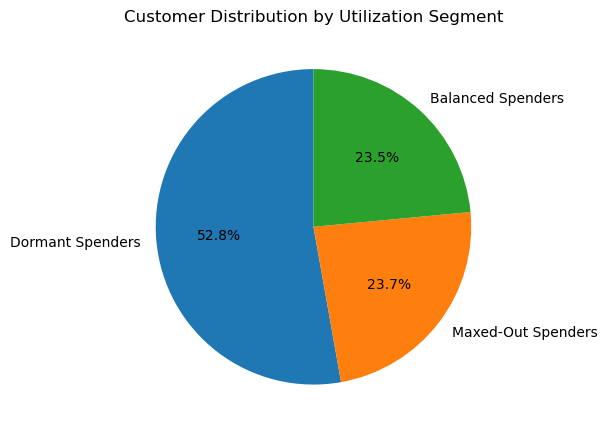

In [39]:
import matplotlib.pyplot as plt

# Value counts for each named cluster
cluster_counts = df["Utilization_Cluster_Name"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    cluster_counts,
    labels=cluster_counts.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Customer Distribution by Utilization Segment")
plt.tight_layout()
plt.show()


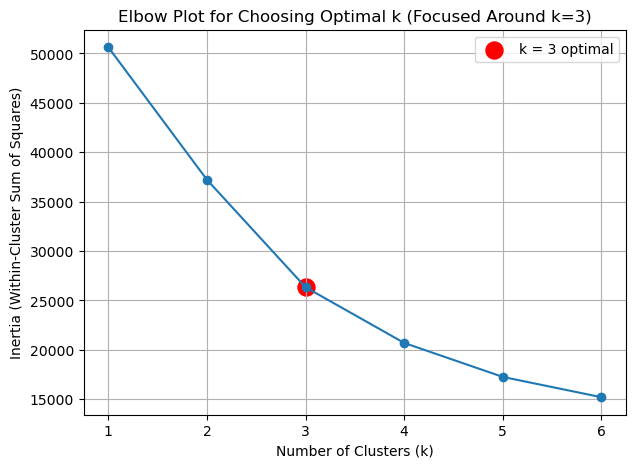

In [40]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
K = range(1, 7)   # Narrow range centered around 3 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7,5))
plt.plot(K, inertia, marker='o', linestyle='-')
plt.xticks(K)
plt.title("Elbow Plot for Choosing Optimal k (Focused Around k=3)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.grid(True)

# Highlight the point for k = 3
plt.scatter(3, inertia[2], color='red', s=150, label="k = 3 optimal")
plt.legend()
plt.show()


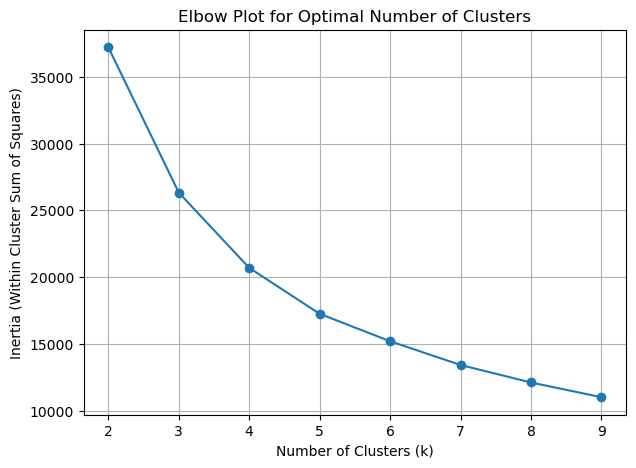

In [41]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
K = range(2, 10)  # Test k from 2 to 9

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7,5))
plt.plot(K, inertia, marker='o', linestyle='-')
plt.xticks(K)
plt.title("Elbow Plot for Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within Cluster Sum of Squares)")
plt.grid(True)
plt.show()


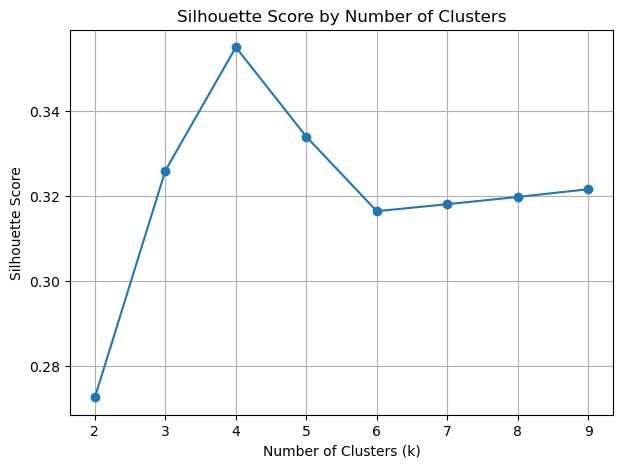

In [42]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(7,5))
plt.plot(K, silhouette_scores, marker='o', linestyle='-')
plt.xticks(K)
plt.title("Silhouette Score by Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


In [43]:
results = pd.DataFrame({
    "k": list(K),
    "Inertia": inertia,
    "Silhouette Score": silhouette_scores
})

results


,k,Inertia,Silhouette Score
0,2,37217.925412,0.272661
1,3,26331.346552,0.325970
2,4,20693.386113,0.354973
3,5,17252.991089,0.333933
4,6,15197.880095,0.316416
5,7,13418.896953,0.318055
6,8,12110.413077,0.319755
7,9,11006.782621,0.321574


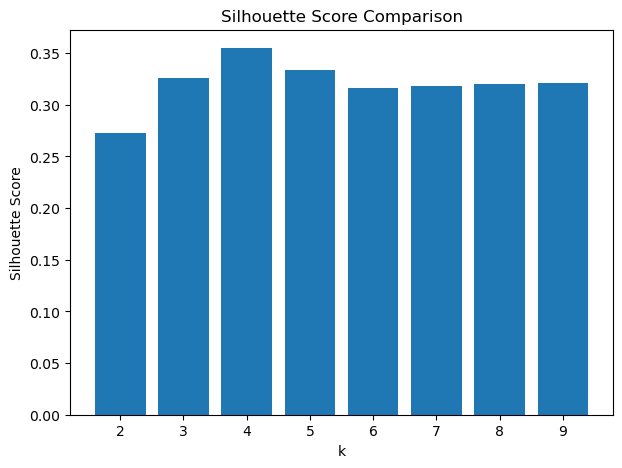

In [44]:
plt.figure(figsize=(7,5))
plt.bar(results["k"], results["Silhouette Score"])
plt.title("Silhouette Score Comparison")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()


In [45]:
from pptx import Presentation
from pptx.util import Inches, Pt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -----------------------------------------------------------
# 1. Run clustering & generate plots for PPT
# -----------------------------------------------------------

inertia = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Save plots as images
# Elbow Plot
plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker='o')
plt.title("Elbow Plot for Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.savefig("elbow_plot.png", dpi=300, bbox_inches="tight")
plt.close()

# Silhouette Plot
plt.figure(figsize=(6,4))
plt.plot(K, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.savefig("silhouette_plot.png", dpi=300, bbox_inches="tight")
plt.close()

# Create DataFrame comparison table
results = pd.DataFrame({
    "k": list(K),
    "Inertia": inertia,
    "Silhouette Score": silhouette_scores
})
results.to_csv("cluster_metrics.csv", index=False)

# -----------------------------------------------------------
# 2. Create PowerPoint presentation
# -----------------------------------------------------------

ppt = Presentation()

# Title Slide
slide = ppt.slides.add_slide(ppt.slide_layouts[0])
slide.shapes.title.text = "Clustering Metrics Evaluation"
slide.placeholders[1].text = "Elbow Method • Silhouette Score • Model Comparison Table"

# Slide 2 – Elbow Plot
slide = ppt.slides.add_slide(ppt.slide_layouts[5])
slide.shapes.title.text = "Elbow Plot"
slide.shapes.add_picture("elbow_plot.png", Inches(1), Inches(1.5), width=Inches(8))

# Slide 3 – Silhouette Plot
slide = ppt.slides.add_slide(ppt.slide_layouts[5])
slide.shapes.title.text = "Silhouette Score Plot"
slide.shapes.add_picture("silhouette_plot.png", Inches(1), Inches(1.5), width=Inches(8))

# Slide 4 – Model Comparison Table
slide = ppt.slides.add_slide(ppt.slide_layouts[1])
slide.shapes.title.text = "Cluster Validity Comparison Table"
body = slide.placeholders[1].text_frame
body.text = str(results)

# Save PPT
ppt.save("Clustering_Metrics_Presentation.pptx")
print("PPT Created Successfully: Clustering_Metrics_Presentation.pptx")


ModuleNotFoundError: No module named 'pptx'

In [46]:
!pip install python-pptx


  Obtaining dependency information for python-pptx from https://files.pythonhosted.org/packages/d9/4f/00be2196329ebbff56ce564aa94efb0fbc828d00de250b1980de1a34ab49/python_pptx-1.0.2-py3-none-any.whl.metadata
  Obtaining dependency information for XlsxWriter>=0.5.7 from https://files.pythonhosted.org/packages/3a/0c/3662f4a66880196a590b202f0db82d919dd2f89e99a27fadef91c4a33d41/xlsxwriter-3.2.9-py3-none-any.whl.metadata
  Obtaining dependency information for typing-extensions>=4.9.0 from https://files.pythonhosted.org/packages/18/67/36e9267722cc04a6b9f15c7f3441c2363321a3ea07da7ae0c0707beb2a9c/typing_extensions-4.15.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/472.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/472.8 kB ? eta -:--:--
    --------------------------------------- 10.2/472.8 kB ? eta -:--:--
    --------------------------------------- 10.2/472.8 kB ? eta -:--:--
   -- ------------------------------------ 30.7/472.8 kB 262.6 kB/s 

In [47]:
conda install -c conda-forge python-pptx



Note: you may need to restart the kernel to use updated packages.Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\HP\anaconda3

  added / updated specs:
    - python-pptx


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.11.12 |       h4c7d964_0         149 KB  conda-forge
    certifi-2025.11.12         |     pyhd8ed1ab_0         153 KB  conda-forge
    python-pptx-1.0.2          |     pyh29332c3_0         404 KB  conda-forge
    xlsxwriter-3.2.9           |     pyhd8ed1ab_0         131 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         838 KB

The following NEW packages will be INSTALLED:

  python-pptx        conda-forge/noarch::python-pptx-1.0.2-pyh29332c3_0 
  xlsxwriter         conda-forge/no



==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 25.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=25.11.0




In [48]:
!pip install python-pptx


In [49]:
from pptx import Presentation
from pptx.util import Inches, Pt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -----------------------------------------------------------
# 1. Run clustering & generate plots for PPT
# -----------------------------------------------------------

inertia = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Save plots as images
# Elbow Plot
plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker='o')
plt.title("Elbow Plot for Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.savefig("elbow_plot.png", dpi=300, bbox_inches="tight")
plt.close()

# Silhouette Plot
plt.figure(figsize=(6,4))
plt.plot(K, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.savefig("silhouette_plot.png", dpi=300, bbox_inches="tight")
plt.close()

# Create DataFrame comparison table
results = pd.DataFrame({
    "k": list(K),
    "Inertia": inertia,
    "Silhouette Score": silhouette_scores
})
results.to_csv("cluster_metrics.csv", index=False)

# -----------------------------------------------------------
# 2. Create PowerPoint presentation
# -----------------------------------------------------------

ppt = Presentation()

# Title Slide
slide = ppt.slides.add_slide(ppt.slide_layouts[0])
slide.shapes.title.text = "Clustering Metrics Evaluation"
slide.placeholders[1].text = "Elbow Method • Silhouette Score • Model Comparison Table"

# Slide 2 – Elbow Plot
slide = ppt.slides.add_slide(ppt.slide_layouts[5])
slide.shapes.title.text = "Elbow Plot"
slide.shapes.add_picture("elbow_plot.png", Inches(1), Inches(1.5), width=Inches(8))

# Slide 3 – Silhouette Plot
slide = ppt.slides.add_slide(ppt.slide_layouts[5])
slide.shapes.title.text = "Silhouette Score Plot"
slide.shapes.add_picture("silhouette_plot.png", Inches(1), Inches(1.5), width=Inches(8))

# Slide 4 – Model Comparison Table
slide = ppt.slides.add_slide(ppt.slide_layouts[1])
slide.shapes.title.text = "Cluster Validity Comparison Table"
body = slide.placeholders[1].text_frame
body.text = str(results)

# Save PPT
ppt.save("Clustering_Metrics_Presentation.pptx")
print("PPT Created Successfully: Clustering_Metrics_Presentation.pptx")

PPT Created Successfully: Clustering_Metrics_Presentation.pptx


In [50]:
ppt.save("Clustering_Metrics_Presentation.pptx")


In [51]:
# =========================
# 1. Imports & Load Data
# =========================
import pandas as pd
import numpy as np

# If df not already loaded:
df = pd.read_csv("DataSet.csv")

# =========================
# 2. Build base RFM table
# =========================
# Map your dataset columns to R, F, M
R_col = "Months_Inactive_12_mon"   # lower = more recent activity
F_col = "Total_Trans_Ct"           # number of transactions
M_col = "Total_Trans_Amt"          # total transaction amount

rfm = df[["CLIENTNUM", R_col, F_col, M_col]].copy()
rfm.rename(columns={
    R_col: "Recency_raw",
    F_col: "Frequency_raw",
    M_col: "Monetary_raw"
}, inplace=True)

# =========================
# 3. Create R, F, M scores (1–5)
# =========================

# --- Recency Score ---
# Fewer inactive months = better (score 5)
# We use fixed bins because Recency has small integer range (0–6)
rfm["R_Score"] = pd.cut(
    rfm["Recency_raw"],
    bins=[-1, 1, 2, 3, 4, rfm["Recency_raw"].max()],  # [0–1], 2, 3, 4, >=5
    labels=[5, 4, 3, 2, 1],
    include_lowest=True
)

# --- Frequency Score ---
# More transactions = better (score 5)
rfm["F_Score"] = pd.qcut(
    rfm["Frequency_raw"].rank(method="first"),
    q=5,
    labels=[1, 2, 3, 4, 5]
)

# --- Monetary Score ---
# Higher total spend = better (score 5)
rfm["M_Score"] = pd.qcut(
    rfm["Monetary_raw"].rank(method="first"),
    q=5,
    labels=[1, 2, 3, 4, 5]
)

# Convert to integers
rfm["R_Score"] = rfm["R_Score"].astype(int)
rfm["F_Score"] = rfm["F_Score"].astype(int)
rfm["M_Score"] = rfm["M_Score"].astype(int)

# =========================
# 4. Overall RFM score
# =========================
rfm["RFM_Score"] = rfm["R_Score"] + rfm["F_Score"] + rfm["M_Score"]

# =========================
# 5. Loyalty segment & flag
# =========================
def loyalty_segment(score):
    if score >= 12:
        return "Champions"        # very high RFM
    elif score >= 9:
        return "Loyal"
    elif score >= 6:
        return "Need Attention"
    else:
        return "At Risk"

rfm["Loyalty_Segment"] = rfm["RFM_Score"].apply(loyalty_segment)
rfm["Loyalty_Flag"] = np.where(rfm["RFM_Score"] >= 9, 1, 0)  # 1 = Loyal/Champion

# Quick check
rfm.head()


,CLIENTNUM,Recency_raw,Frequency_raw,Monetary_raw,R_Score,F_Score,M_Score,RFM_Score,Loyalty_Segment,Loyalty_Flag
0,768805383,1,42,1144,5,2,1,8,Need Attention,0
1,818770008,1,33,1291,5,1,1,7,Need Attention,0
2,713982108,1,20,1887,5,1,1,7,Need Attention,0
3,769911858,4,20,1171,2,1,1,4,At Risk,0
4,709106358,1,28,816,5,1,1,7,Need Attention,0


In [52]:
# Merge RFM info back to original df
df_rfm = df.merge(
    rfm[["CLIENTNUM", "R_Score", "F_Score", "M_Score",
         "RFM_Score", "Loyalty_Segment", "Loyalty_Flag"]],
    on="CLIENTNUM",
    how="left"
)

# Segment summary
segment_summary = rfm.groupby("Loyalty_Segment").agg(
    Customers=("CLIENTNUM", "count"),
    Avg_R=("R_Score", "mean"),
    Avg_F=("F_Score", "mean"),
    Avg_M=("M_Score", "mean"),
    Avg_RFM=("RFM_Score", "mean")
).sort_values("Avg_RFM", ascending=False)

segment_summary


,Customers,Avg_R,Avg_F,Avg_M,Avg_RFM
Loyalty_Segment,,,,,
Champions,3093,4.093437,4.532169,4.498868,13.124475
Loyal,3217,3.545850,3.258626,3.304321,10.108797
Need Attention,3021,3.642833,1.660708,1.642833,6.946375
At Risk,796,2.606784,1.084171,1.096734,4.787688


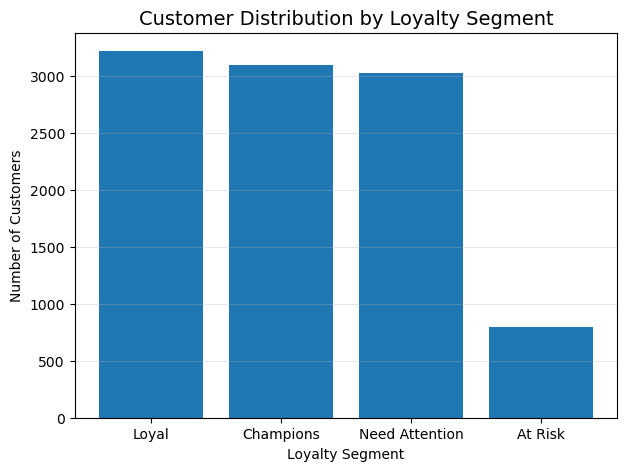

In [53]:
import matplotlib.pyplot as plt

segment_counts = rfm["Loyalty_Segment"].value_counts()

plt.figure(figsize=(7,5))
plt.bar(segment_counts.index, segment_counts.values)
plt.title("Customer Distribution by Loyalty Segment", fontsize=14)
plt.xlabel("Loyalty Segment")
plt.ylabel("Number of Customers")
plt.grid(axis="y", alpha=0.3)
plt.show()


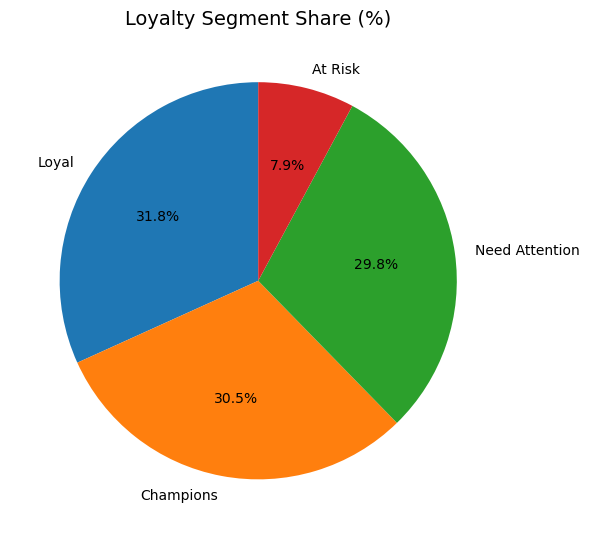

In [54]:
plt.figure(figsize=(6,6))
plt.pie(segment_counts, labels=segment_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Loyalty Segment Share (%)", fontsize=14)
plt.tight_layout()
plt.show()


In [55]:
comparison = pd.crosstab(df_rfm["Loyalty_Segment"], df_rfm["Utilization_Cluster_Name"])
comparison


KeyError: 'Utilization_Cluster_Name'

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.heatmap(comparison, annot=True, fmt="d", cmap="Blues")
plt.title("RFM Loyalty Segments vs Utilization Clusters")
plt.xlabel("Utilization Cluster")
plt.ylabel("Loyalty Segment")
plt.show()


NameError: name 'comparison' is not defined

<Figure size 800x500 with 0 Axes>

In [57]:
df_rfm.columns


Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
       'R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'Loyalty_Segment',
       'Loyalty_Flag'],
      dtype='object')

In [58]:
df_rfm = df_rfm.merge(
    df[["CLIENTNUM", "Utilization_Cluster_Name"]],
    on="CLIENTNUM",
    how="left"
)


KeyError: "['Utilization_Cluster_Name'] not in index"

In [59]:
import numpy as np
import pandas as pd

# 1. Define the mapping from numeric cluster to name
cluster_name_map = {
    1: "Dormant Spenders",     # low utilization
    2: "Balanced Spenders",    # moderate utilization
    0: "Maxed-Out Spenders"    # high utilization
}

# 2. If df_rfm already has numeric Utilization_Cluster, create the name column there
if "Utilization_Cluster_Name" not in df_rfm.columns:
    if "Utilization_Cluster" in df_rfm.columns:
        df_rfm["Utilization_Cluster_Name"] = df_rfm["Utilization_Cluster"].map(cluster_name_map)
    else:
        # fallback: if Utilization_Cluster is only in df, bring it in using CLIENTNUM
        df["Utilization_Cluster_Name"] = df["Utilization_Cluster"].map(cluster_name_map)
        df_rfm = df_rfm.merge(
            df[["CLIENTNUM", "Utilization_Cluster_Name"]],
            on="CLIENTNUM",
            how="left"
        )

# Quick check
df_rfm[["CLIENTNUM", "Loyalty_Segment", "Utilization_Cluster_Name"]].head()


KeyError: 'Utilization_Cluster'

In [60]:
print(df.columns)
print(df_rfm.columns)


Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')
Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_In

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# --- 1. Create Utilization_Ratio column (from Avg_Utilization_Ratio) ---
if "Utilization_Ratio" not in df_rfm.columns:
    df_rfm["Utilization_Ratio"] = df_rfm["Avg_Utilization_Ratio"]

# --- 2. Scale for clustering ---
X_util = df_rfm[["Utilization_Ratio"]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_util)

# --- 3. KMeans with k = 3 (low / medium / high utilisation) ---
kmeans_util = KMeans(n_clusters=3, random_state=42, n_init=10)
df_rfm["Utilization_Cluster"] = kmeans_util.fit_predict(X_scaled)

# --- 4. Order clusters by mean utilization and assign names ---
cluster_means = df_rfm.groupby("Utilization_Cluster")["Utilization_Ratio"].mean().sort_values()
ordered_clusters = list(cluster_means.index)   # [low, mid, high]

cluster_name_map = {
    ordered_clusters[0]: "Dormant Spenders",    # lowest utilisation
    ordered_clusters[1]: "Balanced Spenders",   # medium utilisation
    ordered_clusters[2]: "Maxed-Out Spenders"   # highest utilisation
}

df_rfm["Utilization_Cluster_Name"] = df_rfm["Utilization_Cluster"].map(cluster_name_map)

df_rfm[["CLIENTNUM", "Utilization_Ratio", "Utilization_Cluster", "Utilization_Cluster_Name"]].head()


,CLIENTNUM,Utilization_Ratio,Utilization_Cluster,Utilization_Cluster_Name
0,768805383,0.061,0,Dormant Spenders
1,818770008,0.105,0,Dormant Spenders
2,713982108,0.000,0,Dormant Spenders
3,769911858,0.760,1,Maxed-Out Spenders
4,709106358,0.000,0,Dormant Spenders


In [62]:
comparison = pd.crosstab(
    df_rfm["Loyalty_Segment"],           # from your RFM analysis
    df_rfm["Utilization_Cluster_Name"]   # just created above
)

comparison


Utilization_Cluster_Name,Balanced Spenders,Dormant Spenders,Maxed-Out Spenders
Loyalty_Segment,,,
At Risk,167,462,167
Champions,777,1583,733
Loyal,747,1669,801
Need Attention,691,1677,653


In [63]:
comparison_percent = pd.crosstab(
    df_rfm["Loyalty_Segment"],
    df_rfm["Utilization_Cluster_Name"],
    normalize="index"
) * 100

comparison_percent = comparison_percent.round(2)
comparison_percent


Utilization_Cluster_Name,Balanced Spenders,Dormant Spenders,Maxed-Out Spenders
Loyalty_Segment,,,
At Risk,20.98,58.04,20.98
Champions,25.12,51.18,23.70
Loyal,23.22,51.88,24.90
Need Attention,22.87,55.51,21.62


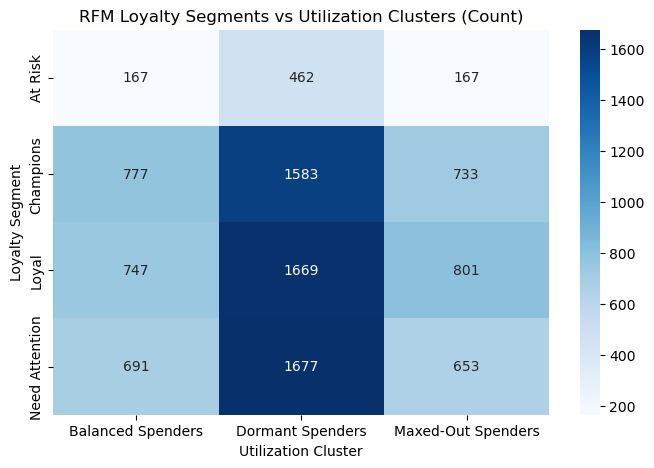

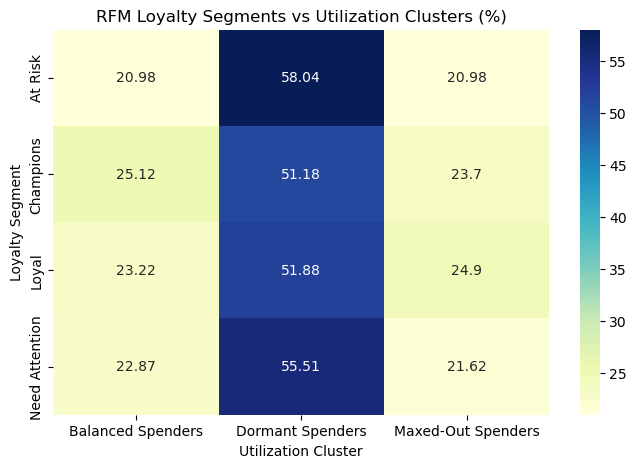

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.heatmap(comparison, annot=True, fmt="d", cmap="Blues")
plt.title("RFM Loyalty Segments vs Utilization Clusters (Count)")
plt.xlabel("Utilization Cluster")
plt.ylabel("Loyalty Segment")
plt.show()

plt.figure(figsize=(8,5))
sns.heatmap(comparison_percent, annot=True, fmt="g", cmap="YlGnBu")
plt.title("RFM Loyalty Segments vs Utilization Clusters (%)")
plt.xlabel("Utilization Cluster")
plt.ylabel("Loyalty Segment")
plt.show()


In [65]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import seaborn as sns
import numpy as np


In [66]:
X = df_rfm[["Utilization_Ratio"]].values  # replace with multiple columns if needed


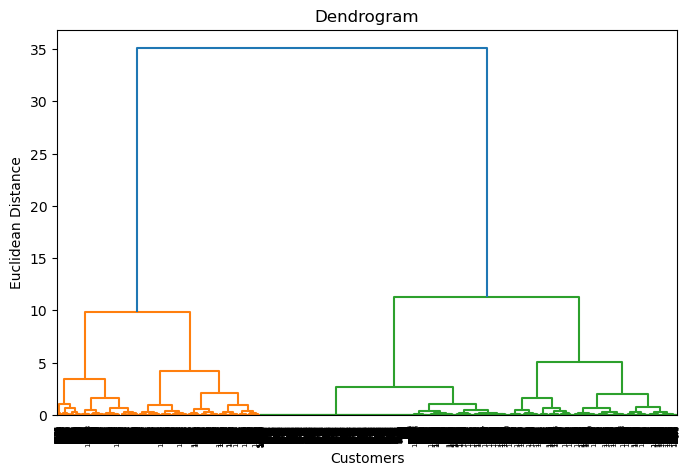

In [67]:
plt.figure(figsize=(8, 5))
sch.dendrogram(sch.linkage(X, method='ward'))
plt.title("Dendrogram")
plt.xlabel("Customers")
plt.ylabel("Euclidean Distance")
plt.show()


In [68]:
agg = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
df_rfm["Agg_Cluster"] = agg.fit_predict(X)


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [69]:
cluster_means = df_rfm.groupby("Agg_Cluster")["Utilization_Ratio"].mean().sort_values()
cluster_means


Agg_Cluster
2    0.024044
1    0.220385
0    0.628321
Name: Utilization_Ratio, dtype: float64

In [70]:
cluster_means = df_rfm.groupby("Agg_Cluster")["Utilization_Ratio"].mean().sort_values()
cluster_means


Agg_Cluster
2    0.024044
1    0.220385
0    0.628321
Name: Utilization_Ratio, dtype: float64

In [71]:
cluster_order = list(cluster_means.index)  # low, mid, high

agg_name_map = {
    cluster_order[0]: "Dormant Spenders",
    cluster_order[1]: "Balanced Spenders",
    cluster_order[2]: "Maxed-Out Spenders"
}

df_rfm["Agg_Cluster_Name"] = df_rfm["Agg_Cluster"].map(agg_name_map)


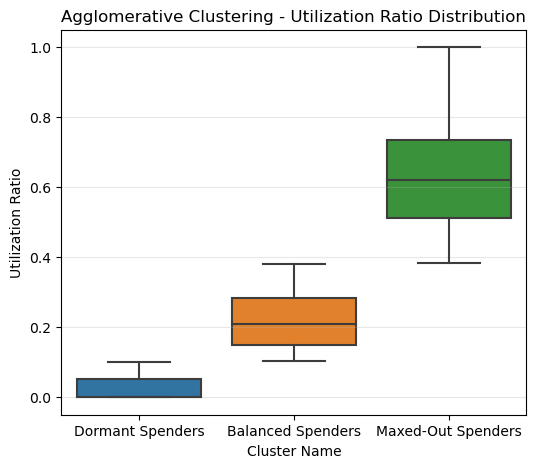

In [72]:
plt.figure(figsize=(6,5))
sns.boxplot(x="Agg_Cluster_Name", y="Utilization_Ratio", data=df_rfm)
plt.title("Agglomerative Clustering - Utilization Ratio Distribution")
plt.xlabel("Cluster Name")
plt.ylabel("Utilization Ratio")
plt.grid(axis="y", alpha=0.3)
plt.show()


In [73]:
df_rfm["Agg_Cluster_Name"].value_counts()


Agg_Cluster_Name
Dormant Spenders      4074
Maxed-Out Spenders    3314
Balanced Spenders     2739
Name: count, dtype: int64

In [74]:
print(df_rfm.columns)


Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
       'R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'Loyalty_Segment',
       'Loyalty_Flag', 'Utilization_Ratio', 'Utilization_Cluster',
       'Utilization_Cluster_Name', 'Agg_Cluster', 'Agg_Cluster_Name'],
      dtype='object')


In [75]:
compare_clusters = pd.crosstab(
    df_rfm["Agg_Cluster_Name"],
    df_rfm["Utilization_Cluster_Name"]
)

compare_clusters


Utilization_Cluster_Name,Balanced Spenders,Dormant Spenders,Maxed-Out Spenders
Agg_Cluster_Name,,,
Balanced Spenders,1422,1317,0
Dormant Spenders,0,4074,0
Maxed-Out Spenders,960,0,2354


In [76]:
compare_clusters_percent = pd.crosstab(
    df_rfm["Agg_Cluster_Name"],
    df_rfm["Utilization_Cluster_Name"],
    normalize="index"
) * 100

compare_clusters_percent = compare_clusters_percent.round(2)
compare_clusters_percent


Utilization_Cluster_Name,Balanced Spenders,Dormant Spenders,Maxed-Out Spenders
Agg_Cluster_Name,,,
Balanced Spenders,51.92,48.08,0.00
Dormant Spenders,0.00,100.00,0.00
Maxed-Out Spenders,28.97,0.00,71.03


In [77]:
compare_clusters_percent = pd.crosstab(
    df_rfm["Agg_Cluster_Name"],
    df_rfm["Utilization_Cluster_Name"],
    normalize="index"
) * 100

compare_clusters_percent = compare_clusters_percent.round(2)
compare_clusters_percent


Utilization_Cluster_Name,Balanced Spenders,Dormant Spenders,Maxed-Out Spenders
Agg_Cluster_Name,,,
Balanced Spenders,51.92,48.08,0.00
Dormant Spenders,0.00,100.00,0.00
Maxed-Out Spenders,28.97,0.00,71.03


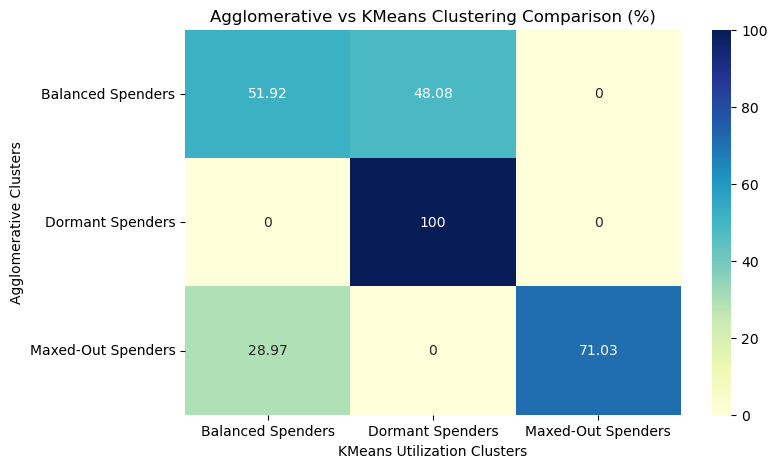

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.heatmap(compare_clusters_percent, annot=True, fmt="g", cmap="YlGnBu")
plt.title("Agglomerative vs KMeans Clustering Comparison (%)")
plt.xlabel("KMeans Utilization Clusters")
plt.ylabel("Agglomerative Clusters")
plt.show()


In [79]:
# Create CLV variables
df_rfm["Avg_Trans_Value"] = df_rfm["Monetary_raw"] / df_rfm["Frequency_raw"].replace(0,1)

# Expected customer lifetime based on Months_on_book
df_rfm["Expected_Lifetime"] = df_rfm["Months_on_book"] / 12  # convert months to years

# Calculate CLV proxy
df_rfm["CLV"] = df_rfm["Frequency_raw"] * df_rfm["Avg_Trans_Value"] * df_rfm["Expected_Lifetime"]


KeyError: 'Monetary_raw'

In [80]:
# Correct columns based on your dataset
df_rfm["Avg_Trans_Value"] = df_rfm["Total_Trans_Amt"] / df_rfm["Total_Trans_Ct"].replace(0,1)

# Expected remaining customer lifetime (years)
df_rfm["Expected_Lifetime"] = df_rfm["Months_on_book"] / 12

# Calculate CLV proxy
df_rfm["CLV"] = df_rfm["Total_Trans_Ct"] * df_rfm["Avg_Trans_Value"] * df_rfm["Expected_Lifetime"]

df_rfm[["CLIENTNUM", "CLV"]].head()


,CLIENTNUM,CLV
0,768805383,3718.000000
1,818770008,4733.666667
2,713982108,5661.000000
3,769911858,3317.833333
4,709106358,1428.000000


In [81]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Drop irrelevant or categorical
X = df_rfm.drop(["CLIENTNUM", "CLV", "Loyalty_Segment", "Loyalty_Flag",
                 "Agg_Cluster_Name", "Attrition_Flag"], axis=1, errors='ignore')

y = df_rfm["CLV"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


ValueError: could not convert string to float: 'M'

In [82]:
# Use only numeric columns for modeling
numeric_cols = df_rfm.select_dtypes(include=["int64", "float64"]).columns

# Drop target + IDs from numeric list
numeric_cols = numeric_cols.drop(
    ["CLV", "CLIENTNUM"], errors="ignore"
)

X = df_rfm[numeric_cols]
y = df_rfm["CLV"]

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


R2 Score: 0.9990943441436804
MAE: 111.5358977733903


In [83]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Separate features & target
y = df_rfm["CLV"]
X = df_rfm.drop(["CLIENTNUM", "CLV"], axis=1)

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

numeric_transformer = "passthrough"
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", RandomForestRegressor(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


R2: 0.999009840265815
MAE: 114.72862701546553


In [84]:
# Correct columns based on your dataset
df_rfm["Avg_Trans_Value"] = df_rfm["Total_Trans_Amt"] / df_rfm["Total_Trans_Ct"].replace(0,1)

# Expected remaining customer lifetime (years)
df_rfm["Expected_Lifetime"] = df_rfm["Months_on_book"] / 12

# Calculate CLV proxy
df_rfm["CLV"] = df_rfm["Total_Trans_Ct"] * df_rfm["Avg_Trans_Value"] * df_rfm["Expected_Lifetime"]

df_rfm[["CLIENTNUM", "CLV"]].head()


,CLIENTNUM,CLV
0,768805383,3718.000000
1,818770008,4733.666667
2,713982108,5661.000000
3,769911858,3317.833333
4,709106358,1428.000000


In [85]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Drop irrelevant or categorical
X = df_rfm.drop(["CLIENTNUM", "CLV", "Loyalty_Segment", "Loyalty_Flag",
                 "Agg_Cluster_Name", "Attrition_Flag"], axis=1, errors='ignore')

y = df_rfm["CLV"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


ValueError: could not convert string to float: 'M'

In [86]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Separate features & target
y = df_rfm["CLV"]
X = df_rfm.drop(["CLIENTNUM", "CLV"], axis=1)

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

numeric_transformer = "passthrough"
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", RandomForestRegressor(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


R2: 0.999009840265815
MAE: 114.72862701546553


In [87]:
import numpy as np
import matplotlib.pyplot as plt

importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.title("Top 10 Predictors of CLV")
plt.show()


AttributeError: 'RandomForestRegressor' object has no attribute 'estimators_'

In [88]:
AttributeError: 'RandomForestRegressor' object has no attribute 'estimators_'


SyntaxError: invalid syntax (2434263962.py, line 1)

In [89]:
# Select only numeric features for CLV prediction
numeric_cols = df_rfm.select_dtypes(include=["int64", "float64"]).columns
numeric_cols = numeric_cols.drop(["CLV", "CLIENTNUM"], errors="ignore")

X = df_rfm[numeric_cols]
y = df_rfm["CLV"]

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


R2: 0.9990943441436804
MAE: 111.5358977733903


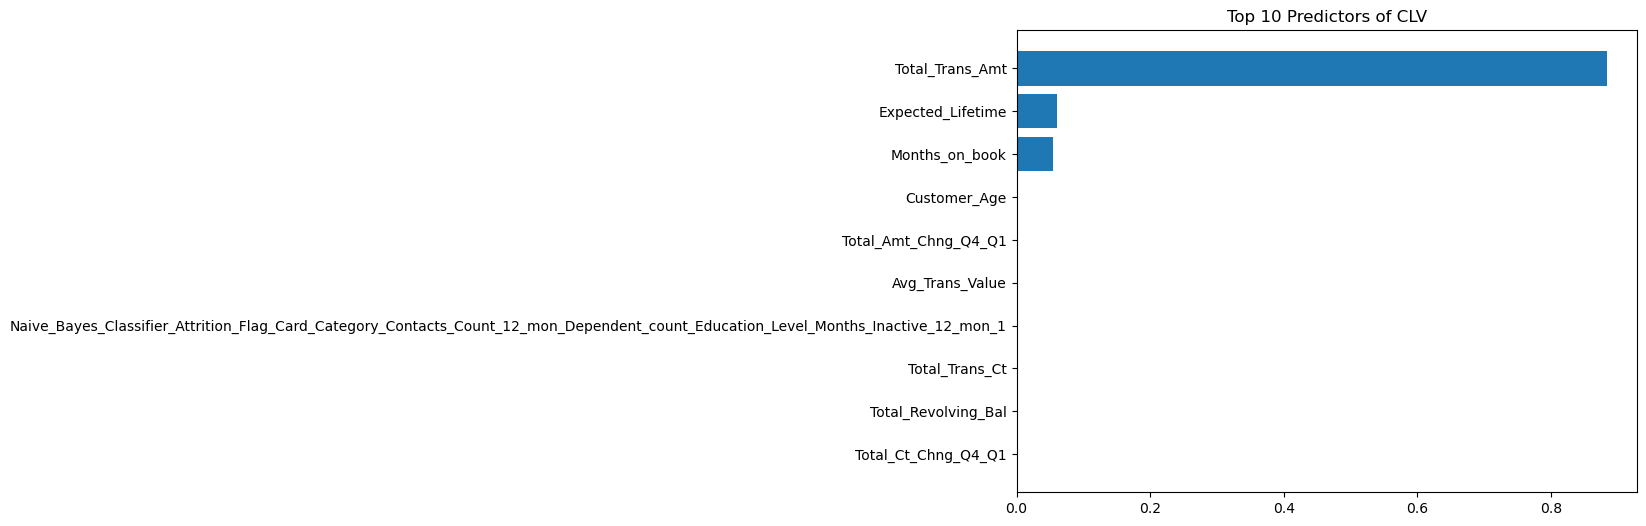

In [90]:
import numpy as np
import matplotlib.pyplot as plt

importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 strongest predictors

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.title("Top 10 Predictors of CLV")
plt.show()


In [91]:
# Example new customer profile
new_customer = {
    "Total_Trans_Amt": 1500,
    "Total_Trans_Ct": 50,
    "Months_on_book": 6,
    "Avg_Utilization_Ratio": 0.25,
    "Total_Relationship_Count": 4,
    "Customer_Age": 35,
    "Total_Revolving_Bal": 800,
    "Total_Ct_Chng_Q4_Q1": 0.2,
    "Total_Amt_Chng_Q4_Q1": 0.25,
    "Expected_Lifetime": 6 / 12
}

import pandas as pd
new_customer_df = pd.DataFrame([new_customer])


In [92]:
predicted_CLV = rf.predict(new_customer_df)
print("Predicted CLV for new customer:", predicted_CLV[0])


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Agg_Cluster
- Avg_Open_To_Buy
- Avg_Trans_Value
- Contacts_Count_12_mon
- Credit_Limit
- ...


In [93]:
numeric_cols = df_rfm.select_dtypes(include=["int64", "float64"]).columns
numeric_cols = numeric_cols.drop(["CLV", "CLIENTNUM"], errors="ignore")

X = df_rfm[numeric_cols]
y = df_rfm["CLV"]


In [94]:
numeric_cols = df_rfm.select_dtypes(include=["int64", "float64"]).columns
numeric_cols = numeric_cols.drop(["CLV", "CLIENTNUM"], errors="ignore")


In [95]:
import pandas as pd

# 1. Start from mean of existing customers for all model features
template = df_rfm[numeric_cols].mean()

# 2. Turn into a one-row DataFrame
new_customer_df = pd.DataFrame([template])


In [96]:
# Example values – change these as needed for your new customer
new_customer_df.loc[0, "Total_Trans_Amt"] = 1500        # expected yearly spend
new_customer_df.loc[0, "Total_Trans_Ct"] = 50           # expected number of transactions
new_customer_df.loc[0, "Months_on_book"] = 6            # initial tenure
new_customer_df.loc[0, "Avg_Utilization_Ratio"] = 0.25  # expected utilization
new_customer_df.loc[0, "Customer_Age"] = 35

# If your model includes Expected_Lifetime column we created earlier:
if "Expected_Lifetime" in numeric_cols:
    new_customer_df.loc[0, "Expected_Lifetime"] = new_customer_df.loc[0, "Months_on_book"] / 12


In [97]:
predicted_CLV = rf.predict(new_customer_df[numeric_cols])
print("Predicted CLV for new customer:", predicted_CLV[0])


Predicted CLV for new customer: 1892.6458333333337


In [98]:
def predict_new_customer_clv(model, df_reference, numeric_cols, new_values_dict):
    # Start from mean row
    row = df_reference[numeric_cols].mean()
    row_df = pd.DataFrame([row])

    # Overwrite any known values
    for col, val in new_values_dict.items():
        if col in numeric_cols:
            row_df.loc[0, col] = val

    # Predict
    return model.predict(row_df[numeric_cols])[0]

# Example usage:
new_customer_info = {
    "Total_Trans_Amt": 1500,
    "Total_Trans_Ct": 50,
    "Months_on_book": 6,
    "Avg_Utilization_Ratio": 0.25,
    "Customer_Age": 35
}

pred_clv = predict_new_customer_clv(rf, df_rfm, numeric_cols, new_customer_info)
print("Predicted CLV:", pred_clv)


Predicted CLV: 3510.346666666667


In [99]:
# Recreate numeric_cols if needed
numeric_cols = df_rfm.select_dtypes(include=["int64", "float64"]).columns
numeric_cols = numeric_cols.drop(["CLV", "CLIENTNUM"], errors="ignore")

# Start from mean of all customers
template = df_rfm[numeric_cols].mean()
new_customer_row = pd.DataFrame([template])

# Overwrite with known values for the new customer
new_customer_row.loc[0, "Total_Trans_Amt"] = 1500
new_customer_row.loc[0, "Total_Trans_Ct"] = 50
new_customer_row.loc[0, "Months_on_book"] = 6
new_customer_row.loc[0, "Avg_Utilization_Ratio"] = 0.25
new_customer_row.loc[0, "Customer_Age"] = 35
if "Expected_Lifetime" in numeric_cols:
    new_customer_row.loc[0, "Expected_Lifetime"] = new_customer_row.loc[0, "Months_on_book"] / 12

# Predict CLV
pred_clv = rf.predict(new_customer_row[numeric_cols])[0]
print("Predicted CLV:", pred_clv)


Predicted CLV: 1892.6458333333337


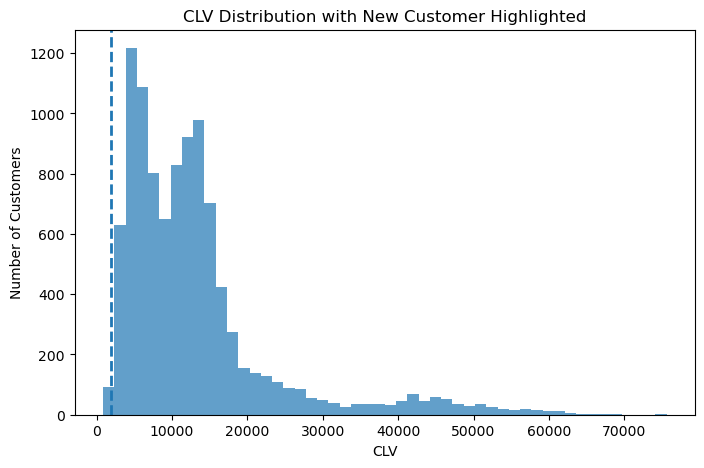

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df_rfm["CLV"], bins=50, alpha=0.7)
plt.axvline(pred_clv, linestyle="--", linewidth=2)
plt.title("CLV Distribution with New Customer Highlighted")
plt.xlabel("CLV")
plt.ylabel("Number of Customers")
plt.show()


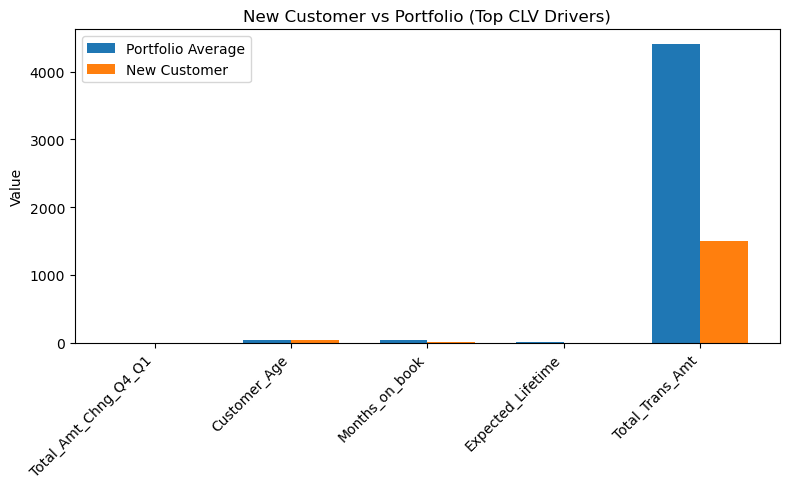

In [101]:
import numpy as np

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[-5:]   # top 5 predictors

top_features = numeric_cols[indices]

pop_means = df_rfm[top_features].mean()
new_values = new_customer_row[top_features].iloc[0]

x = np.arange(len(top_features))

plt.figure(figsize=(8,5))
width = 0.35

plt.bar(x - width/2, pop_means, width, label="Portfolio Average")
plt.bar(x + width/2, new_values, width, label="New Customer")

plt.xticks(x, top_features, rotation=45, ha="right")
plt.title("New Customer vs Portfolio (Top CLV Drivers)")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()


   Total_Trans_Amt  Predicted_CLV
0              500    1258.858333
1             1500    1892.645833
2             3000    3363.317500
3             5000    5419.415000


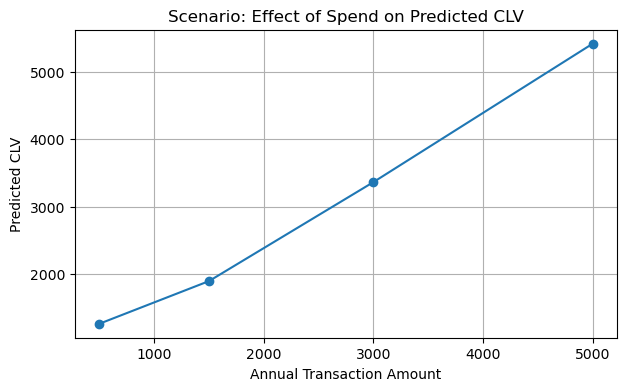

In [102]:
import pandas as pd

scenarios = [500, 1500, 3000, 5000]
scenario_rows = []

for amt in scenarios:
    row = new_customer_row.copy()
    row.loc[0, "Total_Trans_Amt"] = amt
    clv = rf.predict(row[numeric_cols])[0]
    scenario_rows.append({"Total_Trans_Amt": amt, "Predicted_CLV": clv})

scenario_df = pd.DataFrame(scenario_rows)
print(scenario_df)

plt.figure(figsize=(7,4))
plt.plot(scenario_df["Total_Trans_Amt"], scenario_df["Predicted_CLV"], marker="o")
plt.title("Scenario: Effect of Spend on Predicted CLV")
plt.xlabel("Annual Transaction Amount")
plt.ylabel("Predicted CLV")
plt.grid(True)
plt.show()


In [1]:
# Encode card category into numeric labels
df_rfm["Card_Category"] = df_rfm["Card_Category"].astype(str)


NameError: name 'df_rfm' is not defined

In [2]:
# Create a copy for RFM / model work
df_rfm = df.copy()


NameError: name 'df' is not defined

In [3]:
df_rfm["Card_Category"] = df_rfm["Card_Category"].astype(str)


NameError: name 'df_rfm' is not defined

In [4]:
import pandas as pd

# Load your original file
df = pd.read_csv("DataSet.csv")

# Create RFM/Model dataset copy
df_rfm = df.copy()

print(df_rfm.head())   # verify
print(df_rfm.columns)  # verify columns exist


   CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0              39  ...       12691.0                  777          11914.0   
1       

In [5]:
df_rfm["Card_Category"] = df_rfm["Card_Category"].astype(str)


In [6]:
from sklearn.model_selection import train_test_split

# Select features
X = df_rfm.drop(["CLIENTNUM", "Card_Category", "Attrition_Flag", "Loyalty_Segment", 
                 "Loyalty_Flag", "Utilization_Cluster_Name", "Agg_Cluster_Name"], 
                axis=1, errors='ignore')

y = df_rfm["Card_Category"]

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Identify categorical and numeric columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', RandomForestClassifier(random_state=42))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9595261599210266
[[2821    0    0   11]
 [  15    1    0   19]
 [   0    2    0    4]
 [  71    1    0   94]]
              precision    recall  f1-score   support

        Blue       0.97      1.00      0.98      2832
        Gold       0.25      0.03      0.05        35
    Platinum       0.00      0.00      0.00         6
      Silver       0.73      0.57      0.64       166

    accuracy                           0.96      3039
   macro avg       0.49      0.40      0.42      3039
weighted avg       0.95      0.96      0.95      3039



C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


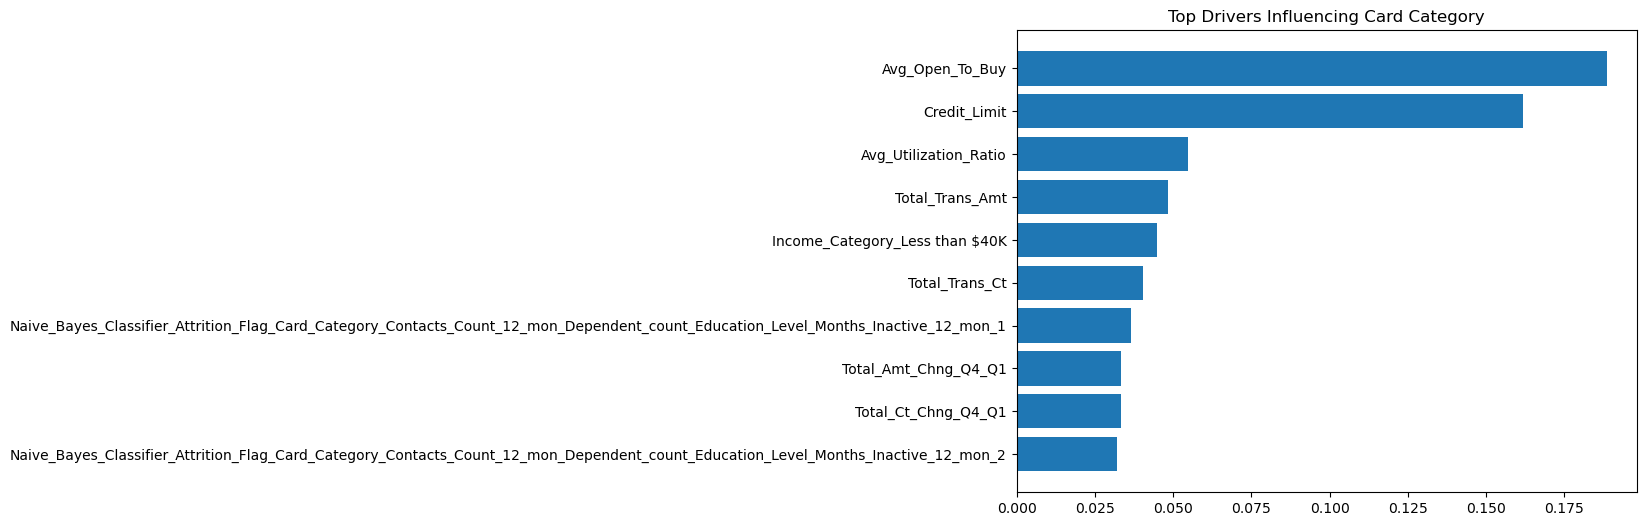

In [9]:
import numpy as np
import matplotlib.pyplot as plt

clf = model.named_steps['clf']
# Extract feature names after encoding
feature_names = list(num_cols) + list(model.named_steps['preprocess'].transformers_[1][1].get_feature_names_out(cat_cols))

importances = clf.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), np.array(feature_names)[indices])
plt.title("Top Drivers Influencing Card Category")
plt.show()


In [10]:
new_customer = {
    "Customer_Age": 32,
    "Total_Trans_Amt": 4000,
    "Total_Trans_Ct": 80,
    "Avg_Utilization_Ratio": 0.42,
    "Credit_Limit": 15000,
    "Months_on_book": 24,
    "Income_Category": "60K-80K",
    "Education_Level": "Graduate",
    "Marital_Status": "Married"
}

import pandas as pd
new_df = pd.DataFrame([new_customer])

pred_card = model.predict(new_df)[0]
print("Recommended Card Category:", pred_card)


ValueError: columns are missing: {'Dependent_count', 'Total_Revolving_Bal', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Avg_Open_To_Buy', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Total_Amt_Chng_Q4_Q1', 'Contacts_Count_12_mon', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', 'Total_Ct_Chng_Q4_Q1'}

In [11]:
X = df_rfm.drop(["CLIENTNUM", "Card_Category", "Attrition_Flag",
                 "Loyalty_Segment", "Loyalty_Flag",
                 "Utilization_Cluster_Name", "Agg_Cluster_Name"],
                axis=1, errors="ignore")

y = df_rfm["Card_Category"]
# then train the pipeline 'model' on X, y


In [12]:
feature_cols = X.columns  # all columns used to fit the model


In [13]:
import pandas as pd

# Split numeric & categorical from training data
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# 1) Start from portfolio averages
template = {}

for col in num_cols:
    template[col] = df_rfm[col].mean()

for col in cat_cols:
    template[col] = df_rfm[col].mode()[0]

# Turn into one-row DataFrame
new_customer_full = pd.DataFrame([template])


In [14]:
import pandas as pd

# Split numeric & categorical from training data
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# 1) Start from portfolio averages
template = {}

for col in num_cols:
    template[col] = df_rfm[col].mean()

for col in cat_cols:
    template[col] = df_rfm[col].mode()[0]

# Turn into one-row DataFrame
new_customer_full = pd.DataFrame([template])


In [15]:
# Example profile – change values to match your new customer
new_customer_profile = {
    "Customer_Age": 32,
    "Total_Trans_Amt": 4000,
    "Total_Trans_Ct": 80,
    "Avg_Utilization_Ratio": 0.42,
    "Credit_Limit": 15000,
    "Months_on_book": 24,
    "Income_Category": "60K-80K",
    "Education_Level": "Graduate",
    "Marital_Status": "Married",
    "Dependent_count": 2
}

for col, val in new_customer_profile.items():
    if col in new_customer_full.columns:
        new_customer_full.loc[0, col] = val


In [16]:
pred_card = model.predict(new_customer_full[feature_cols])[0]
print("Recommended Card Category:", pred_card)


Recommended Card Category: Blue


In [17]:
proba = model.predict_proba(new_customer_full[feature_cols])[0]
for label, p in zip(model.classes_, proba):
    print(f"{label}: {p:.2%}")


Blue: 86.00%
Gold: 0.00%
Platinum: 0.00%
Silver: 14.00%


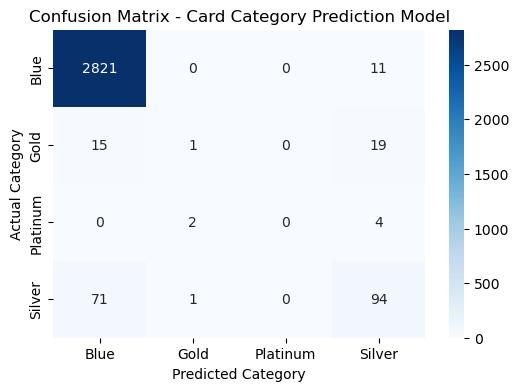

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Plot as heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.title("Confusion Matrix - Card Category Prediction Model")
plt.show()


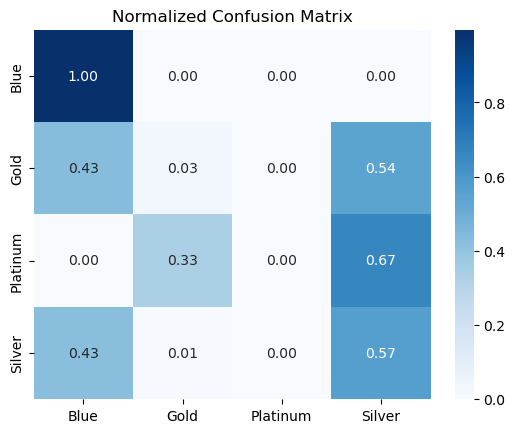

In [19]:
sns.heatmap(cm / cm.sum(axis=1, keepdims=True), annot=True, fmt=".2f",
            cmap="Blues",
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title("Normalized Confusion Matrix")
plt.show()
